# Support Vector Machines: College Admission

Let's look at a classification example in Spark MLLib.  We looked at the college admission before. We can look again at this dataset.  


In [42]:
%matplotlib inline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pandas as pd



## Step 1: Load the data

In [29]:
dataset = spark.read.csv("/data/college-admissions/admission-data.csv", header=True, inferSchema=True)


In [2]:
dataset.show(20)

+-----+---+----+----+
|admit|gre| gpa|rank|
+-----+---+----+----+
|    0|380|3.61|   3|
|    1|660|3.67|   3|
|    1|800| 4.0|   1|
|    1|640|3.19|   4|
|    0|520|2.93|   4|
|    1|760| 3.0|   2|
|    1|560|2.98|   1|
|    0|400|3.08|   2|
|    1|540|3.39|   3|
|    0|700|3.92|   2|
|    0|800| 4.0|   4|
|    0|440|3.22|   1|
|    1|760| 4.0|   1|
|    0|700|3.08|   2|
|    1|700| 4.0|   1|
|    0|480|3.44|   3|
|    0|780|3.87|   4|
|    0|360|2.56|   3|
|    0|800|3.75|   2|
|    1|540|3.81|   1|
+-----+---+----+----+
only showing top 20 rows



## Step 2: Visualize the data

We cannot visualize the data because there is too many components. However, we can use PCA as
a dimensionality reduction technique to visualize it.

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


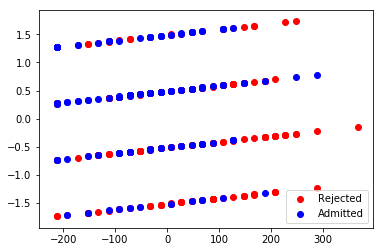

In [30]:
pca = PCA(n_components=2)

data = dataset.toPandas()

y = data['admit']          # Split off classifications
X = data.ix[:, 'gre':] # Split off features
#X_norm = (X - X.min())/(X.max() - X.min())
#transformed = pd.DataFrame(pca.fit_transform(X_norm))
transformed = pd.DataFrame(pca.fit_transform(X))

transformed

plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Rejected', c='red')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Admitted', c='blue')

plt.legend()




How separable does this data appear to be?  Do you notice any trends in the red and blue dots?

## Step 3: Build the Vector

In [43]:
assembler = VectorAssembler(inputCols=['admit', 'gre', 'gpa'], outputCol="features")
featureVector = assembler.transform(training)
featureVector = featureVector.withColumnRenamed("admit", "label")

## Step 4: Split into training and test.

In [ ]:
## Split into training and test
(training, test) = dataset.randomSplit([0.8, 0.2])

## Step 5: Build the Linear SVM model

In [35]:
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(featureVector)

# Print the coefficients and intercept for linearsSVC
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))


Coefficients: [2.77818816767,-0.000269945422381,-0.370929441584]
Intercept: -0.07992357661221175


## Step 6: Run the test set and get the predictions

In [38]:
featureVector_test = assembler.transform(training)
featureVector_test = featureVector_test.withColumnRenamed("admit", "label")

predictions = lsvcModel.transform(featureVector_test)

predictions.show()

+-----+---+----+----+----------------+--------------------+----------+
|label|gre| gpa|rank|        features|       rawPrediction|prediction|
+-----+---+----+----+----------------+--------------------+----------+
|    0|220|2.83|   3|[0.0,220.0,2.83]|[1.18904188921871...|       0.0|
|    0|300|2.92|   4|[0.0,300.0,2.92]|[1.24402117275177...|       0.0|
|    0|300|3.01|   3|[0.0,300.0,3.01]|[1.27740482249432...|       0.0|
|    0|340| 2.9|   1| [0.0,340.0,2.9]|[1.24740040081534...|       0.0|
|    0|340|3.15|   3|[0.0,340.0,3.15]|[1.34013276121133...|       0.0|
|    0|360|2.56|   3|[0.0,360.0,2.56]|[1.12668329912442...|       0.0|
|    0|360| 3.0|   3| [0.0,360.0,3.0]|[1.28989225342136...|       0.0|
|    0|360|3.14|   1|[0.0,360.0,3.14]|[1.34182237524312...|       0.0|
|    0|380|2.91|   4|[0.0,380.0,2.91]|[1.26190751212643...|       0.0|
|    0|380|2.94|   3|[0.0,380.0,2.94]|[1.27303539537395...|       0.0|
|    0|380|3.33|   4|[0.0,380.0,3.33]|[1.41769787759170...|       0.0|
|    0

## Step 7: See the evaluation metrics

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)  #AUC


What does AUC = 1 mean?

In [47]:

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))


Test Error = 0


## Step 8: Show the confusion matrix

In [54]:
# Confusion matrix
predictions.groupBy('label').pivot('prediction', [0,1]).count().na.fill(0).orderBy('label').show()

+-----+---+---+
|label|  0|  1|
+-----+---+---+
|    0|226|  0|
|    1|  0|103|
+-----+---+---+

